In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # pour désactiver les warnings de tensorflow

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from data_by_window import make_windows, put_windows_back_together
from callback import PlotLearning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, AveragePooling1D, Flatten, Dense, LSTM

In [2]:
# dataset of power consumption. X is global consumption, y is the consumptions of 4 appliances
df_x = pd.read_csv("X_train.csv")
df_y = pd.read_csv("y_train.csv")
df_x = df_x.interpolate(method="linear")
df_y = df_y.interpolate(method="linear")

window_size = 120
step = 2
features = ["consumption"]
''' x_win = make_windows(df_x, window_size, features, step)
y_win = make_windows(df_y, window_size, ["washing_machine", "fridge_freezer", "TV", "kettle"], step)

# separate the data into train and test
x_train = x_win[:int(0.8*len(x_win))]
y_train = y_win[:int(0.8*len(y_win))]
x_test = x_win[int(0.8*len(x_win)):]
y_test = y_win[int(0.8*len(y_win)):]

# Reshaping the tensors
x_train = tf.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
y_train = tf.reshape(y_train, (y_train.shape[0], y_train.shape[1]*y_train.shape[2]))
x_test = tf.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))
y_test = tf.reshape(y_test, (y_test.shape[0], y_test.shape[1]*y_test.shape[2])) '''

' x_win = make_windows(df_x, window_size, features, step)\ny_win = make_windows(df_y, window_size, ["washing_machine", "fridge_freezer", "TV", "kettle"], step)\n\n# separate the data into train and test\nx_train = x_win[:int(0.8*len(x_win))]\ny_train = y_win[:int(0.8*len(y_win))]\nx_test = x_win[int(0.8*len(x_win)):]\ny_test = y_win[int(0.8*len(y_win)):]\n\n# Reshaping the tensors\nx_train = tf.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))\ny_train = tf.reshape(y_train, (y_train.shape[0], y_train.shape[1]*y_train.shape[2]))\nx_test = tf.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))\ny_test = tf.reshape(y_test, (y_test.shape[0], y_test.shape[1]*y_test.shape[2])) '

In [4]:
y_train.shape

TensorShape([166992, 480])

In [5]:
# scaling the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

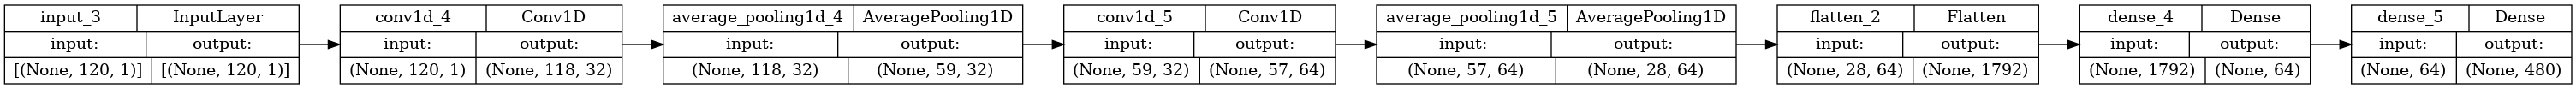

In [5]:
# build the model
model = Sequential()
model.add(InputLayer(input_shape=(window_size, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4*window_size, activation='sigmoid'))

# compile the model with absolute error
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# generating a graph to summarize the model horizontaly

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR")


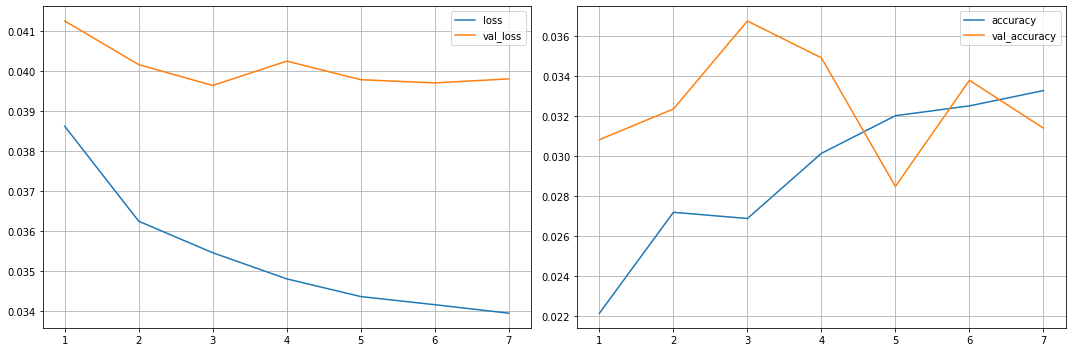

166992/166992 [==============================] - 707s 4ms/step - loss: 0.0340 - accuracy: 0.0333 - val_loss: 0.0398 - val_accuracy: 0.0314
Epoch 8/20
110629/166992 [==================>...........] - ETA: 3:44 - loss: 0.0339 - accuracy: 0.0334

KeyboardInterrupt: 

In [7]:
# train the model with callback
history = model.fit(x_train, y_train, epochs=20, batch_size=1, validation_data=(x_test, y_test), callbacks=[PlotLearning()])

In [ ]:
# export the model
model.save("model.h5")
pd.DataFrame(history.history).to_csv("history.csv")

In [8]:
# predict the test data
y_pred = model.predict(x_test)

1305/1305 [==============================] - 6s 4ms/step


(83520, 4)
(83520, 4)


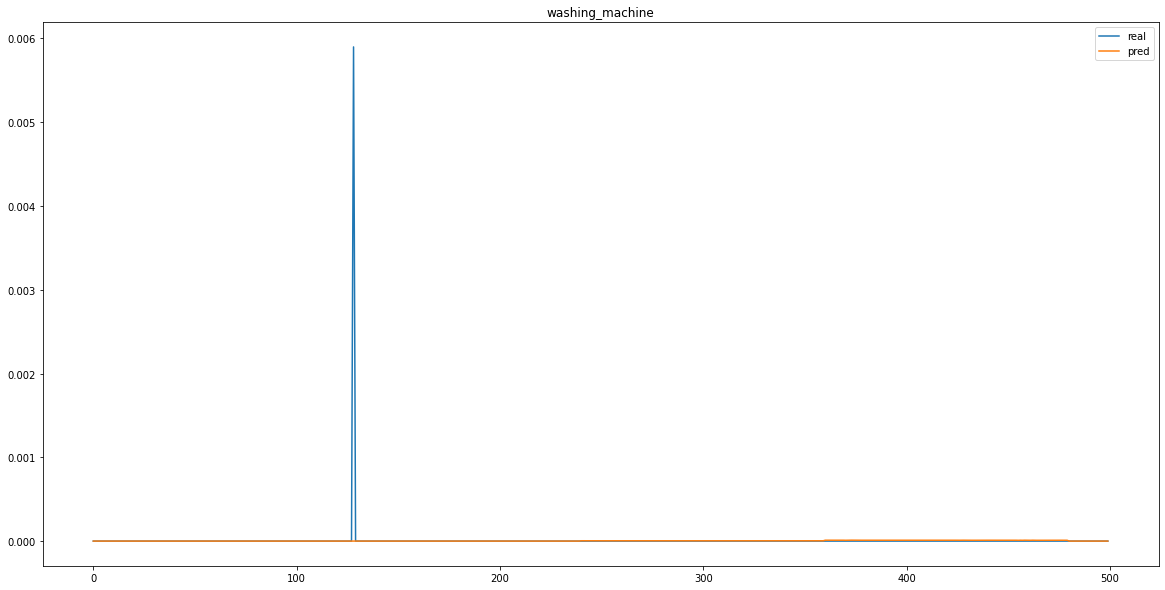

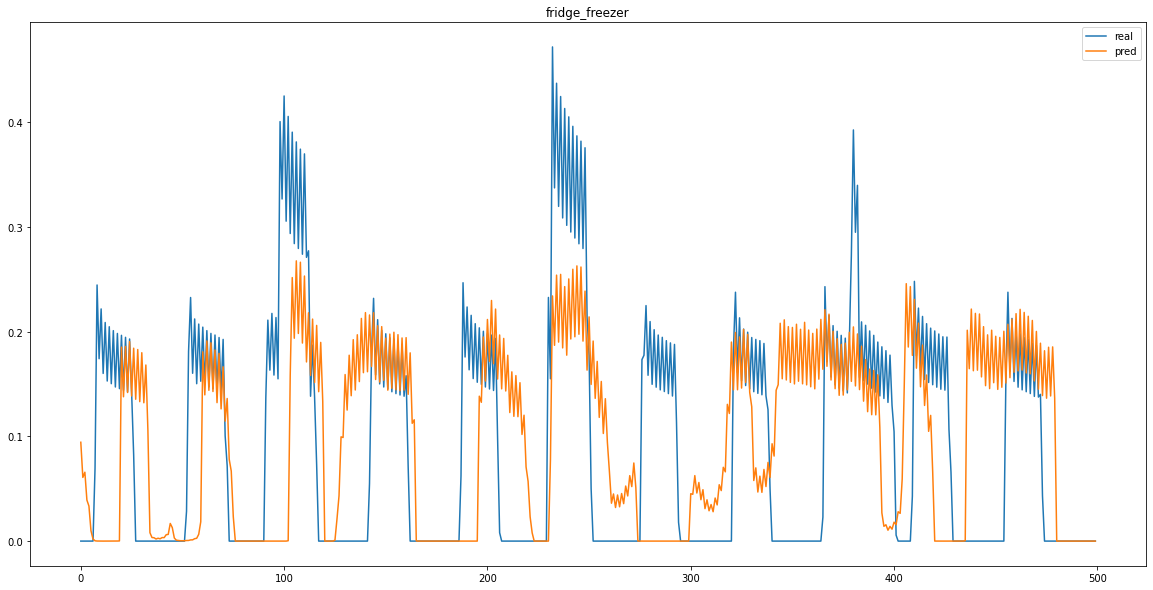

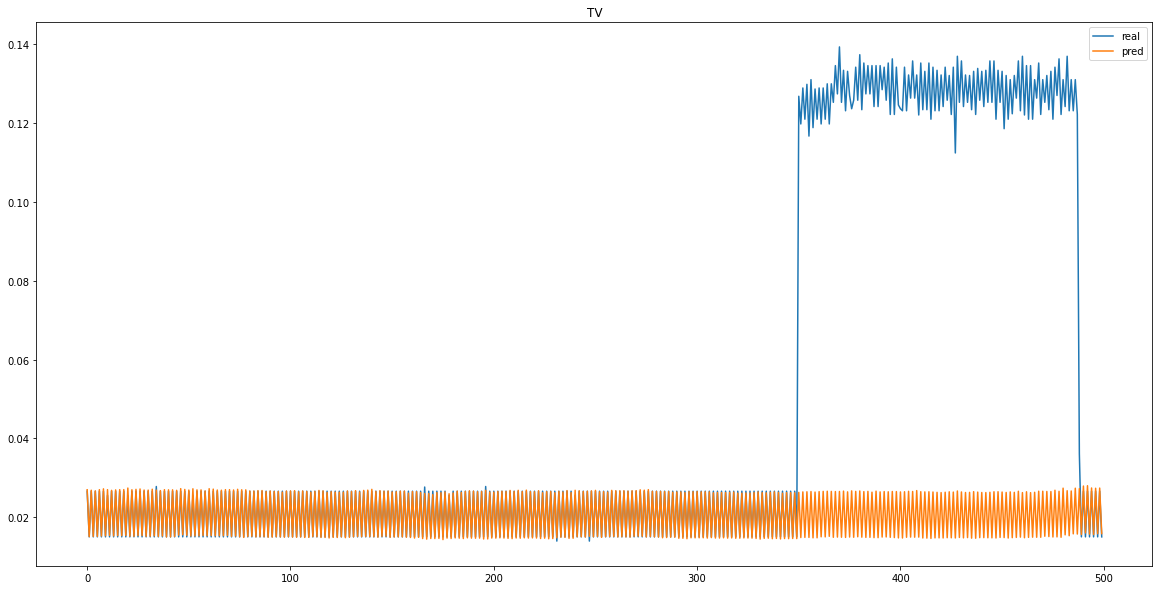

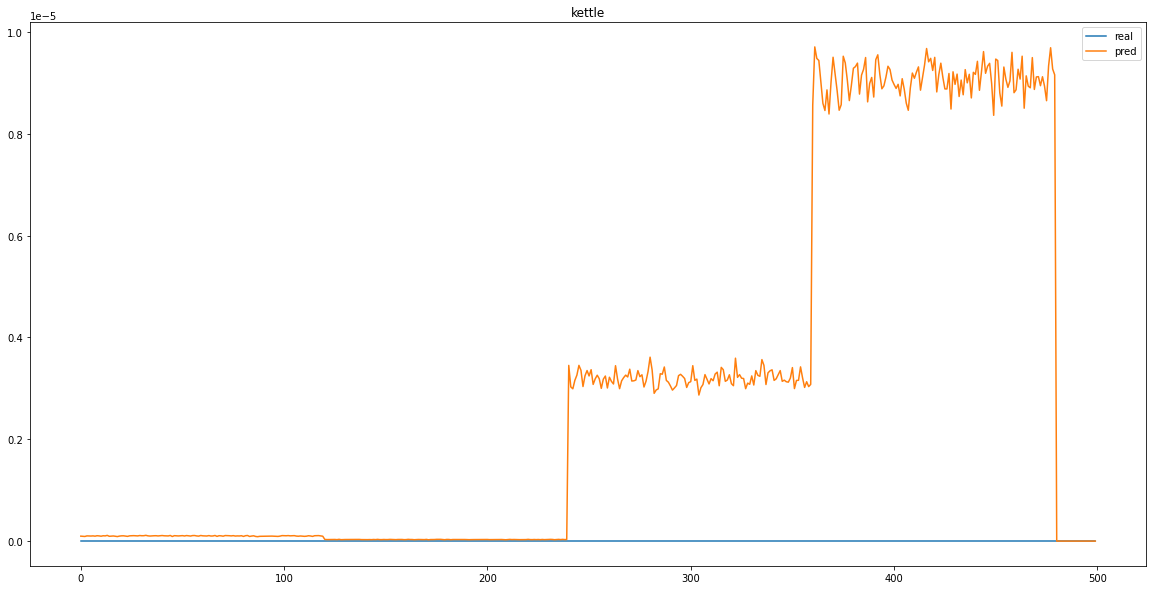

In [14]:
# separate the prediction and data into the 4 appliances
y_pred = tf.reshape(y_pred, (y_pred.shape[0], window_size, 4))
y_test = tf.reshape(y_test, (y_test.shape[0], window_size, 4))

# using put_windows_back_together
y_pred_plot = put_windows_back_together(y_pred, window_size, step)
y_test_plot = put_windows_back_together(y_test, window_size, step)

print(y_pred_plot.shape)
print(y_test_plot.shape)

# washing_machine
plt.figure(figsize=(20, 10),num="washing_machine")
plt.plot(y_test_plot[:500, 0], label="real")
plt.plot(y_pred_plot[:500, 0], label="pred")
plt.title("washing_machine")
plt.legend()
plt.show()

# fridge_freezer
plt.figure(figsize=(20, 10),num="fridge_freezer")
plt.plot(y_test_plot[:500, 1], label="real")
plt.plot(y_pred_plot[:500, 1], label="pred")
plt.title("fridge_freezer")
plt.legend()
plt.show()

# TV
plt.figure(figsize=(20, 10),num="TV")
plt.plot(y_test_plot[:500, 2], label="real")
plt.plot(y_pred_plot[:500, 2], label="pred")
plt.title("TV")
plt.legend()
plt.show()

# kettle
plt.figure(figsize=(20, 10),num="kettle")
plt.plot(y_test_plot[:500, 3], label="real")
plt.plot(y_pred_plot[:500, 3], label="pred")
plt.title("kettle")
plt.legend()
plt.show()

In [ ]:
# import and process the test data
df_x_test = pd.read_csv("X_test.csv")
df_x_test = df_x_test.interpolate(method="linear")
x_test_win = make_windows(df_x_test, window_size, features, step)
x_test_win = tf.reshape(x_test_win, (x_test_win.shape[0], x_test_win.shape[1]*x_test_win.shape[2]))
x_test_win = scaler.fit_transform(x_test_win)

# predict the test data
y_pred_test = model.predict(x_test_win)

# separate the prediction and data into the 4 appliances
y_pred_test = tf.reshape(y_pred_test, (y_pred_test.shape[0], 60, 4))

# using put_windows_back_together
y_pred_test_plot = put_windows_back_together(y_pred_test, window_size, step)

y_pred_test_plot.shape

In [ ]:
# rebuild a y_test.csv for the same appliances and the time stamps "time_step"
df_y_test = pd.DataFrame(columns=["time_step", "washing_machine", "fridge_freezer", "TV", "kettle"])
df_y_test["time_step"] = df_x_test["time_step"]

# add zeros at the end of the prediction to match the length of the test data
y_pred_test_plot = np.concatenate((y_pred_test_plot, np.zeros((len(df_x_test)-len(y_pred_test_plot), 4))), axis=0)

df_y_test["washing_machine"] = y_pred_test_plot[:, 0]
df_y_test["fridge_freezer"] = y_pred_test_plot[:, 1]
df_y_test["TV"] = y_pred_test_plot[:, 2]
df_y_test["kettle"] = y_pred_test_plot[:, 3]

df_y_test.to_csv("y_test.csv", index=False)